# Multi-Agent Reinforcement Learning with TF-Agents

In this notebook we're going to be implementing reinforcement learning (RL) agents to play games against one another. Before reading this it is advised to be familiar with the [TF-Agents](https://github.com/tensorflow/agents) and Deep Q-Learning; [this tutorial](https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb) will bring you up to speed.

### Introduction

TF-Agents is a framework for designing and experimenting with RL algorithms. It provides a collection of useful abstractions such as agents, replay buffers, and drivers. However, the code is quite rigidly tied to the single-agent view, which is explained by the *extrinsically motivated* agent in the diagram below.

In this view, the environment provides observations and rewards to the agent. Under the assumption that there is only one agent this makes sense, however, when we have many agents in the same space we would like to have agent-specific observations and rewards. In order to rectify this we first need to think of agents as *intrinsically motivated*, which is to say that their rewards are a function of their observations and internal state. Secondly, the agent is only *partially observing* the environment, and the window into the environment is a function of the agent's total state. This total state can include "physical" properties of the agent such as position, but it also includes internal state. For example, an agent could have an internal `is_sleeping` parameter that multiplies their observations by zero to simulate a lack of light.

### Intrinsic Motivation

In order to implement this with TF-Agents we are going to define an `IMAgent` (Intrinsically Motivated Agent) class by overriding the `DqnAgent` class. In the standard TF-Agents DQN pipeline the agent is trained by alternating between data collection and training updates to the Q-Network. Data collection is done with a special `collect_policy` which behaves differently to the main policy for the sake of managing the exploitation-exploration trade-off. Usually, the environment and the agent are separated. The environment generates a `TimeStep` containing the observation and reward information which is then passed to `policy.action`. This produces a `PolicyStep` that contains an action to step the environment. 

<p align="center">
<img src="./im_rl_agent.png" width="600px" display="block" margin-left="auto" margin-right="auto" class="center"/>
</p>

This provides us with two approaches to our problem. We could make the enviroment aware of which agent it is producing the `TimeStep` for, or we could have each agent ingest an agent-independent time step that is then augmented internally. Here we argue that the latter is a more natural decomposition as it keeps the agent-specific code with the agent class. 

### Running this Code

The following is the list of imports that we will need for this tutorial. In order to run the code yourself you should clone [the repository](https://github.com/DylanCope/Multi-Agent-RL-with-TF) from GitHub and use [Anaconda](https://docs.conda.io/en/latest/) and the `env.yaml` file to [recreate the Python environment](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file).

In [2]:
from functools import partial
from IPython.display import clear_output
from itertools import cycle
from pathlib import Path
import random
from time import time
from typing import Tuple, List, Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import tensorflow as tf
from tf_agents.agents import DqnAgent
from tf_agents.agents.tf_agent import LossInfo
from tf_agents.environments.py_environment import PyEnvironment
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.networks.q_rnn_network import QRnnNetwork
from tf_agents.networks.q_network import QNetwork
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.specs import TensorSpec
from tf_agents.trajectories import trajectory
from tf_agents.trajectories.time_step import TimeStep
from tf_agents.trajectories.trajectory import Trajectory
from tf_agents.utils import common

print('Physical Devices:\n', tf.config.list_physical_devices(), '\n\n')

OUTPUTS_DIR = f'./outputs/{int(10000000 * time())}'
print('Output Directory:', OUTPUTS_DIR)

Physical Devices:
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')] 


Output Directory: ./outputs/15923139163402452


### Defining the IMAgent Class

In the next cell we will be defining the `IMAgent` class. This class is designed to be relatively general, but it could be improved by adding support for other reinforcement learning algorithms. The most natural way to do this would be by composition, rather than inheritance.

In [3]:
class IMAgent(DqnAgent):

    def __init__(self,
                 env: TFPyEnvironment,
                 observation_spec: TensorSpec = None,
                 action_spec: TensorSpec = None,
                 reward_fn: Callable = lambda time_step: time_step.reward,
                 action_fn: Callable = lambda action: action,
                 name: str='IMAgent',
                 q_network=None,
                 # training params
                 replay_buffer_max_length: int = 1000,
                 learning_rate: float = 1e-5,
                 training_batch_size: int = 8,
                 training_parallel_calls: int = 3,
                 training_prefetch_buffer_size: int = 3,
                 training_num_steps: int = 2,
                 **dqn_kwargs):

        self._env = env
        self._reward_fn = reward_fn
        self._name = name
        self._observation_spec = observation_spec or self._env.observation_spec()
        self._action_spec = action_spec or self._env.action_spec()
        self._action_fn = action_fn

        q_network = q_network or self._build_q_net()

        env_ts_spec = self._env.time_step_spec()
        time_step_spec = TimeStep(
            step_type=env_ts_spec.step_type,
            reward=env_ts_spec.reward,
            discount=env_ts_spec.discount,
            observation=q_network.input_tensor_spec
        )

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        super().__init__(time_step_spec,
                         self._action_spec,
                         q_network,
                         optimizer,
                         name=name,
                         **dqn_kwargs)

        self._policy_state = self.policy.get_initial_state(
            batch_size=self._env.batch_size)
        self._rewards = []

        self._replay_buffer = TFUniformReplayBuffer(
            data_spec=self.collect_data_spec,
            batch_size=self._env.batch_size,
            max_length=replay_buffer_max_length)
        
        self._training_batch_size = training_batch_size
        self._training_parallel_calls = training_parallel_calls
        self._training_prefetch_buffer_size = training_prefetch_buffer_size
        self._training_num_steps = training_num_steps
        self.train = common.function(self.train)

    def _build_q_net(self):
#         q_net = QRnnNetwork(input_tensor_spec=self._observation_spec,
#                             action_spec=self._action_spec,
#                             name=f'{self._name}QRNN')

        fc_layer_params = (50,)

        q_net = QNetwork(
            self._observation_spec,
            self._action_spec,
            fc_layer_params=fc_layer_params)

        q_net.create_variables()
        q_net.summary()
        
        return q_net

    def reset(self):
        self._policy_state = self.policy.get_initial_state(
            batch_size=self._env.batch_size
        )
        self._rewards = []
        
    def episode_return(self) -> float:
        return np.sum(self._rewards)
        
    def _observation_fn(self, observation: tf.Tensor) -> tf.Tensor:
        """
            Takes a tensor with specification self._env.observation_spec
            and extracts a tensor with specification self._observation_spec.
            
            For example, consider an agent within an NxN maze environment. 
            The env could expose the entire NxN integer matrix as an observation
            but we would prefer the agent to only see a 3x3 window around their
            current location. To do this we can override this method.
            
            This allows us to have different agents acting in the same environment
            with different observations.
        """
        return observation

    def _augment_time_step(self, time_step: TimeStep) -> TimeStep:

        reward = self._reward_fn(time_step)
        reward = tf.convert_to_tensor(reward, dtype=tf.float32)
        if reward.shape != time_step.reward.shape:
            reward = tf.reshape(reward, time_step.reward.shape)
            
        observation = self._observation_fn(time_step.observation)

        return TimeStep(
            step_type=time_step.step_type,
            reward=reward,
            discount=time_step.discount,
            observation=observation
        )

    def _current_time_step(self) -> TimeStep:
        time_step = self._env.current_time_step()
        time_step = self._augment_time_step(time_step)
        return time_step

    def _step_environment(self, action) -> TimeStep:
        action = self._action_fn(action)
        time_step = self._env.step(action)
        time_step = self._augment_time_step(time_step)
        return time_step

    def act(self, collect=False) -> Trajectory:
        time_step = self._current_time_step()

        if collect:
            policy_step = self.collect_policy.action(
                time_step, policy_state=self._policy_state)
        else:
            policy_step = self.policy.action(
                time_step, policy_state=self._policy_state)

        self._policy_state = policy_step.state
        next_time_step = self._step_environment(policy_step.action)
        traj = trajectory.from_transition(time_step, policy_step, next_time_step)

        self._rewards.append(next_time_step.reward)
        
        if collect:
            self._replay_buffer.add_batch(traj)

        return traj

    def train_iteration(self) -> LossInfo:
        experience, info = self._replay_buffer.get_next(
            sample_batch_size=self._training_batch_size,
            num_steps=self._training_num_steps
        )
        return self.train(experience)

## Tic-Tac-Toe 

<p align="center">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Tic_tac_toe.svg/1200px-Tic_tac_toe.svg.png" width="300px" class="center"/>
</p>

In order to test this we can utlise the [already-implemented Tic-Tac-Toe environment](https://github.com/tensorflow/agents/blob/master/tf_agents/environments/examples/tic_tac_toe_environment.py) in TF-Agents (At the time of writing this script has not been added to the pip distribution so I have manually copied it across). The environment represents the problem on a 3x3 matrix where a 0 represents an empty slot, a 1 represents a play by player 1, and a 2 represents a play by player 2. However, as TF-Agents is not focused on the multi-agent case, their implementation has the second player act randomly. To change this we will override the step function.

The only additional change that we need to make is to the action specification, where we need to provide the value that is being placed (i.e. which player is making the move).

In [4]:
from tic_tac_toe_environment import TicTacToeEnvironment
from tf_agents.specs import BoundedArraySpec
from tf_agents.trajectories.time_step import StepType

REWARD_ILLEGAL_MOVE = np.asarray(-5, dtype=np.float32)

class TicTacToeMultiAgentEnv(TicTacToeEnvironment):
    
    def action_spec(self):
        position_spec = BoundedArraySpec((1,), np.int32, minimum=0, maximum=8)
        value_spec = BoundedArraySpec((1,), np.int32, minimum=1, maximum=2)
        return {
            'position': position_spec,
            'value': value_spec
        }
    
    def _step(self, action: np.ndarray):
        if self._current_time_step.is_last():
            return self._reset()

        index_flat = np.array(range(9)) == action['position']
        index = index_flat.reshape(self._states.shape) == True
        if self._states[index] != 0:
            return TimeStep(StepType.LAST, 
                            REWARD_ILLEGAL_MOVE,
                            self._discount, 
                            self._states)

        self._states[index] = action['value']

        is_final, reward = self._check_states(self._states)
        
        if np.all(self._states == 0):
            step_type = StepType.FIRST
        elif is_final:
            step_type = StepType.LAST
        else:
            step_type = StepType.MID

        return TimeStep(step_type, reward, self._discount, self._states)

In [5]:
def print_tic_tac_toe(state):
    table_str = '''
    {} | {} | {}
    - + - + -
    {} | {} | {}
    - + - + -
    {} | {} | {}
    '''.format(*tuple(state.flatten()))
    table_str = table_str.replace('0', ' ')
    table_str = table_str.replace('1', 'X')
    table_str = table_str.replace('2', 'O')
    print(table_str)

For a test of the environment we will step the environment with random actions:

In [6]:
tic_tac_toe_env = TicTacToeMultiAgentEnv()

ts = tic_tac_toe_env.reset()
print('Reward:', ts.reward, 'Board:')
print_tic_tac_toe(ts.observation)

random.seed(1)
player = 1
while not ts.is_last():
    action = {
        'position': np.asarray(random.randint(0, 8)),
        'value': player
    }
    ts = tic_tac_toe_env.step(action)
    print('Player:', player, 'Action:', action['position'],
          'Reward:', ts.reward, 'Board:')
    print_tic_tac_toe(ts.observation)
    player = 1 + player % 2

Reward: 0.0 Board:

      |   |  
    - + - + -
      |   |  
    - + - + -
      |   |  
    
Player: 1 Action: 2 Reward: 0.0 Board:

      |   | X
    - + - + -
      |   |  
    - + - + -
      |   |  
    
Player: 2 Action: 1 Reward: 0.0 Board:

      | O | X
    - + - + -
      |   |  
    - + - + -
      |   |  
    
Player: 1 Action: 4 Reward: 0.0 Board:

      | O | X
    - + - + -
      | X |  
    - + - + -
      |   |  
    
Player: 2 Action: 1 Reward: -5.0 Board:

      | O | X
    - + - + -
      | X |  
    - + - + -
      |   |  
    


## Creating Player Objects

Each of our players will be instances of `IMAgent` with a differing action and reward functions. The actions that the players make are dictionaries with position and value items, specifying what marking the player is trying to make on the board. Player 1 will get the default +1 for a win and -1 for a loss, but will will need to invert these rewards for Player 2.  

In [7]:
def ttt_action_fn(player, action):
    return {'position': action, 'value': player}

tf_ttt_env = TFPyEnvironment(tic_tac_toe_env)

player_1 = IMAgent(
    tf_ttt_env,
    action_spec = tf_ttt_env.action_spec()['position'],
    action_fn = partial(ttt_action_fn, 1),
    name='Player1'
)

def p2_reward_fn(ts: TimeStep) -> float:
    if ts.reward == -1.0:
        return 1.0
    if ts.reward == 1.0:
        return -1.0
    return ts.reward

player_2 = IMAgent(
    tf_ttt_env,
    action_spec = tf_ttt_env.action_spec()['position'],
    action_fn = partial(ttt_action_fn, 2),
    reward_fn = p2_reward_fn,
    name='Player2'
)

Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  500       
_________________________________________________________________
dense (Dense)                multiple                  459       
Total params: 959
Trainable params: 959
Non-trainable params: 0
_________________________________________________________________
Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  500       
_________________________________________________________________
dense_2 (Dense)              multiple                  459       
Total params: 959
Trainable params: 959
Non-trainable params: 0
_________________________________________________________________


In [8]:
ts = tf_ttt_env.reset()

# arbitrary starting point to add variety
random.seed(1)
start_player_id = random.randint(1, 2)
tf_ttt_env.step({
    'position': tf.convert_to_tensor([random.randint(0, 8)]), 
    'value': start_player_id
})
ts = tf_ttt_env.current_time_step()
print('Random start board:')
print_tic_tac_toe(ts.observation.numpy())

if start_player_id == 2:
    players = cycle([player_1, player_2])
else:
    players = cycle([player_2, player_1])
    
while not ts.is_last():
    player = next(players)
    player.act()
    ts = tf_ttt_env.current_time_step()
    print(f'Player: {player.name}, Reward: {ts.reward[0]}')
    print_tic_tac_toe(ts.observation.numpy())

Random start board:

      | X |  
    - + - + -
      |   |  
    - + - + -
      |   |  
    
Player: Player2, Reward: 0.0

      | X |  
    - + - + -
      |   | O
    - + - + -
      |   |  
    
Player: Player1, Reward: 0.0

      | X | X
    - + - + -
      |   | O
    - + - + -
      |   |  
    
Player: Player2, Reward: -5.0

      | X | X
    - + - + -
      |   | O
    - + - + -
      |   |  
    


As we can see, the agents properly interact with the environment, even if they are currently unable to perform well.

In order to verify that the end condition rewards are all correct, we will engineer a winning state for each player and print out the appropriate information: 

In [23]:
ts = tf_ttt_env.reset()

for pos in [0, 4, 8]:
    tf_ttt_env.step({
        'position': tf.convert_to_tensor([pos]), 
        'value': 2
    })

ts = tf_ttt_env.current_time_step()
print_tic_tac_toe(ts.observation.numpy())
print('Is Final Step:', TimeStep.is_last(ts).numpy()[0])
print('Player 1 Reward:', player_1._augment_time_step(ts).reward.numpy()[0])
print('Player 2 Reward:', player_2._augment_time_step(ts).reward.numpy()[0])


    O |   |  
    - + - + -
      | O |  
    - + - + -
      |   | O
    
Is Final Step: True
Player 1 Reward: -1.0
Player 2 Reward: 1.0


In [22]:
ts = tf_ttt_env.reset()

for pos in [0, 4, 8]:
    tf_ttt_env.step({
        'position': tf.convert_to_tensor([pos]), 
        'value': 1
    })

ts = tf_ttt_env.current_time_step()
print_tic_tac_toe(ts.observation.numpy())
print('Is Final Step:', TimeStep.is_last(ts).numpy()[0])
print('Player 1 Reward:', player_1._augment_time_step(ts).reward.numpy()[0])
print('Player 2 Reward:', player_2._augment_time_step(ts).reward.numpy()[0])


    X |   |  
    - + - + -
      | X |  
    - + - + -
      |   | X
    
Is Final Step: True
Player 1 Reward: 1.0
Player 2 Reward: -1.0


## Training the Agents

<p align="center">
<img src="https://miro.medium.com/max/2784/1*_5dltx4BcI8rRmCK2Sq_kw.png" width="500px" class="center"/>
</p>

In order to train the agents we will do a iterations of 'episodes' and training steps. Each episode is a game of Tic Tac Toe where the agents use their 'collect policies' and store the trajectories that they experience in replay buffers. These collect policies are *epsilon greedy*: some percentage of the time (10\% in our case) the agents will perform a random action rather then following the best suggestion of the Q-networks. This is to balance the [exploration-exploitation trade-off](https://towardsdatascience.com/intuition-exploration-vs-exploitation-c645a1d37c7a). The agents are *Independent Q-learners* (IQL), meaning that they do not share parameters or experience. This means that each store their experience to their own buffers and separately use these datasets to update thier own weights. A side-effect of IQL is that the agents may learn strategies that the other has not, leading to chaotic learning dynamics where the loss scores of each agent fluctuate in tandem with one another throughout the training iterations.  

The following cell defines the logic of a single training episode where we randomly pick one of the two players to go first. This is important because Tic Tac Toe is a [*solved game*](https://en.wikipedia.org/wiki/Solved_game): whoever plays first can force a win or a draw if they play optimally. Therefore, as the agents master the game we should expect the win rate to trend towards 50\% (when the $\epsilon$-greedy policy is not in use).

In [35]:
def training_episode(tf_ttt_env, player_1, player_2):
    ts = tf_ttt_env.reset()
    player_1.reset()
    player_2.reset()
    time_steps = []
    if bool(random.randint(0, 1)):
        players = cycle([player_1, player_2])
    else:
        players = cycle([player_2, player_1])
    while not ts.is_last():
        player = next(players)
        player.act(collect=True)
        ts = tf_ttt_env.current_time_step()
        time_steps.append(ts)
    return time_steps

### Inspecting the Trajectories

First, lets verify that the trajectories are being written to the buffers:

In [36]:
for _ in range(10):
    training_episode(tf_ttt_env, player_1, player_2)

print('Number of trajectories recorded by P1:',
      player_1._replay_buffer.num_frames().numpy())
print('Number of trajectories recorded by P2:',
      player_2._replay_buffer.num_frames().numpy())

Number of trajectories recorded by P1: 27
Number of trajectories recorded by P2: 27


To better understand what is being stored in the buffers, lets visualising a sample from Player 1:

In [118]:
tf.random.set_seed(5)
traj_batches, info = player_1._replay_buffer.get_next(
    num_steps=2, sample_batch_size=3)

def print_traj(traj):
    steps = tf.concat(list(traj), axis=-1)
    table_str = '''Trajectory:
      Start             End
    {} | {} | {}        {} | {} | {}
    - + - + -        - + - + -
    {} | {} | {}   ->   {} | {} | {}
    - + - + -        - + - + -
    {} | {} | {}        {} | {} | {}
    '''.format(*tuple(steps.numpy().flatten()))
    table_str = table_str.replace('0', ' ')
    table_str = table_str.replace('1', 'X')
    table_str = table_str.replace('2', 'O')
    print(table_str)
    
for i in range(3):
    action = traj_batches.action[i, 0, 0].numpy()
    print('Action: Place \'X\' at', 
          (action % 3, action // 3))
    reward = traj_batches.reward[i, 0].numpy()
    print('Reward:', reward)
    print_traj(traj_batches.observation[i])
    print()

Action: Place 'X' at (2, 0)
Reward: -5.0
Trajectory:
      Start             End
    O |   | X          |   |  
    - + - + -        - + - + -
    O |   |     ->     |   |  
    - + - + -        - + - + -
    X |   | O          |   |  
    

Action: Place 'X' at (0, 0)
Reward: 0.0
Trajectory:
      Start             End
      |   |          X |   |  
    - + - + -        - + - + -
      |   |     ->   O |   |  
    - + - + -        - + - + -
      |   |            |   |  
    

Action: Place 'X' at (0, 2)
Reward: 0.0
Trajectory:
      Start             End
    O |   |          O |   |  
    - + - + -        - + - + -
      |   |     ->   O |   |  
    - + - + -        - + - + -
      |   |          X |   |  
    



The replay buffer `get_next` method allows us to choose the size of the batch and the number of time steps in each sample. Here we have three trajectories, each showing one transition. We can see that from the perspective of Player 1 the other agent's actions just appear in the next time step.


## Training Loops and Plotting

In this next cell we define the core training loop and history plotting functions. For each episode we are recording data on the outcome, and player returns (sum of rewards over the episode) and other metadata. For each training step we are recording loss information. We are then taking all this information and creating plots that get created and updated at regular intervals.

In [19]:
def collect_training_data():
    for game in range(episodes_per_iteration):
        training_episode(tf_ttt_env, player_1, player_2)

        p1_return = player_1.episode_return()
        p2_return =  player_2.episode_return()

        if REWARD_ILLEGAL_MOVE in [p1_return, p2_return]:
            outcome = 'illegal'
        elif p1_return == TicTacToeEnvironment.REWARD_WIN:
            outcome = 'p1_win'
        elif p2_return == TicTacToeEnvironment.REWARD_WIN:
            outcome = 'p2_win'
        else:
            outcome = 'draw'
        
        games.append({
            'iteration': iteration,
            'game': game,
            'p1_return': p1_return,
            'p2_return': p2_return,
            'outcome': outcome,
            'final_step': tf_ttt_env.current_time_step()
        })

def train():
    for _ in range(train_steps_per_iteration):
        p1_train_info = player_1.train_iteration()
        p2_train_info = player_2.train_iteration()
    
        loss_infos.append({
            'iteration': iteration,
            'p1_loss': p1_train_info.loss.numpy(),
            'p2_loss': p2_train_info.loss.numpy()
        })

def plot_history():
    
    games_data = pd.DataFrame.from_records(games)
    loss_data = pd.DataFrame.from_records(loss_infos)
    loss_data['Player 1'] = np.log(loss_data.p1_loss)
    loss_data['Player 2'] = np.log(loss_data.p2_loss)
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    
    loss_melted = pd.melt(loss_data, 
                          id_vars=['iteration'], 
                          value_vars=['Player 1', 'Player 2'])
    smoothing = iteration // 50
    loss_melted.iteration = smoothing * (loss_melted.iteration // smoothing)

    sns.lineplot(ax=axs[0][0], 
                 x='iteration', hue='variable', 
                 y='value', data=loss_melted)
    axs[0][0].set_title('Loss History')
    axs[0][0].set_ylabel('log-loss')
    
    returns_melted = pd.melt(games_data, 
                             id_vars=['iteration'], 
                             value_vars=['p1_return', 'p2_return'])
    returns_melted.iteration = smoothing * (returns_melted.iteration // smoothing)
    sns.lineplot(ax=axs[0][1], 
                 x='iteration', hue='variable', 
                 y='value', data=returns_melted)
    axs[0][1].set_title('Return History')
    axs[0][1].set_ylabel('return')

    games_data['p1_win'] = games_data.outcome == 'p1_win'
    games_data['p2_win'] = games_data.outcome == 'p2_win'
    games_data['illegal'] = games_data.outcome == 'illegal'
    grouped_games_data = games_data.groupby('iteration')
    cols = ['game', 'p1_win', 'p2_win', 'illegal']
    grouped_games_data = grouped_games_data[cols]
    game_totals =  grouped_games_data.max()['game'] + 1
    summed_games_data = grouped_games_data.sum()
    summed_games_data['p1_win_rate'] = summed_games_data.p1_win / game_totals
    summed_games_data['p2_win_rate'] = summed_games_data.p2_win / game_totals
    summed_games_data['illegal_rate'] = summed_games_data.illegal / game_totals
    summed_games_data['iteration'] = smoothing * (summed_games_data.index // smoothing)
    
    sns.lineplot(ax=axs[1][0],
                 x='iteration',
                 y='p1_win_rate',
                 data=summed_games_data,
                 label='Player 1 Win Rate')
    sns.lineplot(ax=axs[1][0],
                 x='iteration',
                 y='p2_win_rate',
                 data=summed_games_data,
                 label='Player 2 Win Rate')
    sns.lineplot(ax=axs[1][0],
                 x='iteration',
                 y='illegal_rate',
                 data=summed_games_data,
                 label='Illegal Ending Rate')
    axs[1][0].set_title('Outcomes History')
    axs[1][0].set_ylabel('ratio')
    
    plt.show()

## Final Training Set-up 

Here we are defining the parameters for the training run and building the agents. Most of these parameters are straight forward and don't require much consideration, but the `replay_buffer_size` is particular to the circumstances. Usually, in single-agent reinforcement learning, the environment is *stationary*, meaning that state-transitions and rewards that were observed in the past can be assumed to have stable distributions. However, in the IQL setting the expected return changes as the other agents in your environment change their strategies. This means that data stored in the replay buffer quickly becomes out-of-date, leading the training gradients of the loss function to not accurately reflect a step in the direction of improved performance at the present. As a result, if we have large replay buffers we see the loss function *increase*, rather than decrease, as we train. The TF-Agents `TFUniformReplayBuffer` implements a first in, first out (FIFO) mechanism, so if we restrict the maximum size to only store the trajectories for the past few iterations we will make sure that the environment appears approximately stationary from the perspective of the training step.

In [35]:
num_iterations = 2000
initial_collect_episodes = 100
episodes_per_iteration = 10
train_steps_per_iteration = 1
training_batch_size = 512
training_num_steps = 2
replay_buffer_size = 3 * episodes_per_iteration * 9
learning_rate = 1e-2
plot_interval = 50

In [36]:
iteration = 1
games = []
loss_infos = []

player_1 = IMAgent(
    tf_ttt_env,
    action_spec = tf_ttt_env.action_spec()['position'],
    action_fn = partial(ttt_action_fn, 1),
    name='Player1',
    learning_rate = learning_rate,
    training_batch_size = training_batch_size,
    training_num_steps = training_num_steps,
    replay_buffer_max_length = replay_buffer_size,
    td_errors_loss_fn=common.element_wise_squared_loss
)

player_2 = IMAgent(
    tf_ttt_env,
    action_spec = tf_ttt_env.action_spec()['position'],
    action_fn = partial(ttt_action_fn, 2),
    reward_fn = p2_reward_fn,
    name='Player2',
    learning_rate = learning_rate,
    training_batch_size = training_batch_size,
    training_num_steps = training_num_steps,
    replay_buffer_max_length = replay_buffer_size,
    td_errors_loss_fn=common.element_wise_squared_loss
)

print('Collecting Initial Training Sample...')
for _ in range(initial_collect_episodes):
    training_episode(tf_ttt_env, player_1, player_2)
print('Samples collected')

Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  500       
_________________________________________________________________
dense_12 (Dense)             multiple                  459       
Total params: 959
Trainable params: 959
Non-trainable params: 0
_________________________________________________________________
Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  500       
_________________________________________________________________
dense_14 (Dense)             multiple                  459       
Total params: 959
Trainable params: 959
Non-trainable params: 0
_________________________________________________________________
Samples collected


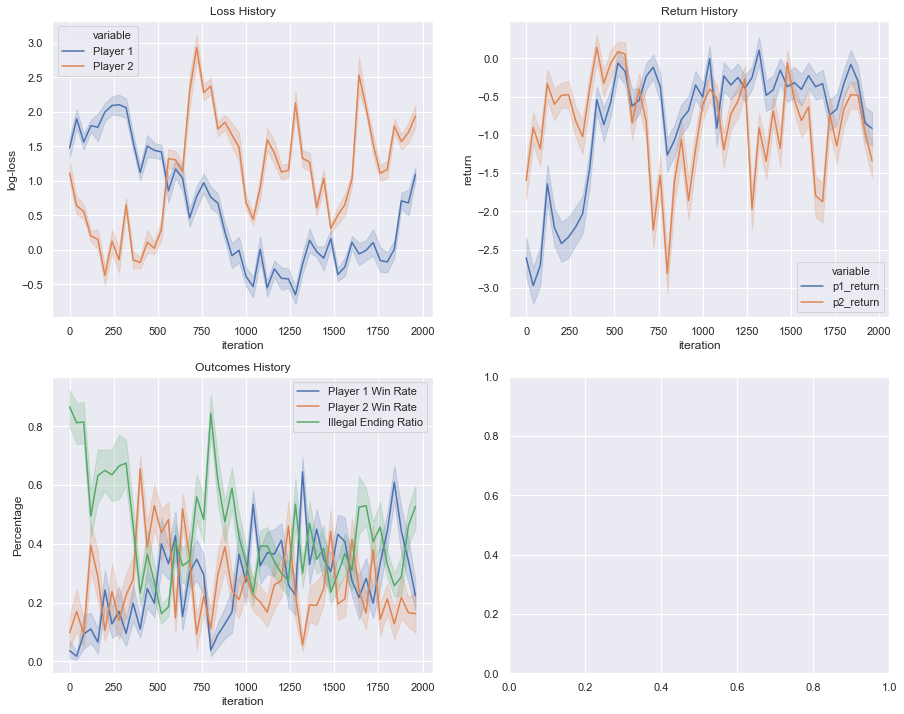

In [37]:
try:
    if iteration > 1:
        plot_history()
        clear_output(wait=True)
    while iteration < num_iterations:
        collect_training_data()
        train()
        iteration += 1
        if iteration % plot_interval == 0:
            plot_history()
            clear_output(wait=True)

except KeyboardInterrupt:
    clear_output(wait=True)
    print('Interrupting training, plotting history...')
    plot_history()

## Evaluating the Agents

Now that we have training the agents to play the game, we can see them play some games.

First, lets see what happens when player 1 goes first:

In [38]:
ts = tf_ttt_env.reset()
player_1.reset()
player_2.reset()
print('Start:')
print_tic_tac_toe(ts.observation.numpy())

players = cycle([player_1, player_2])
while not ts.is_last():
    player = next(players)
    traj = player.act()
    ts = player._current_time_step()
    act = traj.action[0][0]
    print(f'Player: {player.name}, '
          f'Action: {(act % 3, act // 3)}, '
          f'Reward: {ts.reward.numpy()[0]}')
    print_tic_tac_toe(ts.observation.numpy())

Start:

      |   |  
    - + - + -
      |   |  
    - + - + -
      |   |  
    
Player: Player1, Action: 5, Reward: 0.0

      |   |  
    - + - + -
      |   | X
    - + - + -
      |   |  
    
Player: Player2, Action: 4, Reward: 0.0

      |   |  
    - + - + -
      | O | X
    - + - + -
      |   |  
    
Player: Player1, Action: 3, Reward: 0.0

      |   |  
    - + - + -
    X | O | X
    - + - + -
      |   |  
    
Player: Player2, Action: 2, Reward: 0.0

      |   | O
    - + - + -
    X | O | X
    - + - + -
      |   |  
    
Player: Player1, Action: 0, Reward: 0.0

    X |   | O
    - + - + -
    X | O | X
    - + - + -
      |   |  
    
Player: Player2, Action: 7, Reward: 0.0

    X |   | O
    - + - + -
    X | O | X
    - + - + -
      | O |  
    
Player: Player1, Action: 6, Reward: 1.0

    X |   | O
    - + - + -
    X | O | X
    - + - + -
    X | O |  
    


Now, lets see what happens when player 2 goes first:

In [39]:
ts = tf_ttt_env.reset()
player_1.reset()
player_2.reset()
print('Start:')
print_tic_tac_toe(ts.observation.numpy())

players = cycle([player_2, player_1])
while not ts.is_last():
    player = next(players)
    traj = player.act()
    ts = player._current_time_step()
    act = traj.action[0][0]
    print(f'Player: {player.name}, '
          f'Action: {(act % 3, act // 3)}, '
          f'Reward: {ts.reward.numpy()[0]}')
    print_tic_tac_toe(ts.observation.numpy())

Start:

      |   |  
    - + - + -
      |   |  
    - + - + -
      |   |  
    
Player: Player2, Action: 3, Reward: 0.0

      |   |  
    - + - + -
    O |   |  
    - + - + -
      |   |  
    
Player: Player1, Action: 8, Reward: 0.0

      |   |  
    - + - + -
    O |   |  
    - + - + -
      |   | X
    
Player: Player2, Action: 4, Reward: 0.0

      |   |  
    - + - + -
    O | O |  
    - + - + -
      |   | X
    
Player: Player1, Action: 2, Reward: 0.0

      |   | X
    - + - + -
    O | O |  
    - + - + -
      |   | X
    
Player: Player2, Action: 0, Reward: 0.0

    O |   | X
    - + - + -
    O | O |  
    - + - + -
      |   | X
    
Player: Player1, Action: 6, Reward: 0.0

    O |   | X
    - + - + -
    O | O |  
    - + - + -
    X |   | X
    
Player: Player2, Action: 7, Reward: 0.0

    O |   | X
    - + - + -
    O | O |  
    - + - + -
    X | O | X
    
Player: Player1, Action: 1, Reward: 0.0

    O | X | X
    - + - + -
    O | O |  
    - + - + -
    X | 

As we can see, the agents have (mostly) learned to avoid illegal moves, however, they are still missing obvious opportunties to win the game or block their opponent. Further training and/or changing the agent architectures would likely improve their play. 


## Conclusions

In this tutorial we have implemented a class for intrinsically motivated DQN agents using TF-Agents, and we have instantiated multiple agents to act as independent Q-learners in a Tic Tac Toe environment. This framework is general a should be easily adaptable to different agent types, more agents, and different environments. 